In [2]:
ler_ibge_ipca_subitem <- function(data, plot = NULL, top_n = NULL){
  options(warn = -1)
  pacotes <- c("readxl", "dplyr", "tibble", "ggplot2", "ggthemes")
  instalados <- installed.packages()
  faltam <- pacotes[!(pacotes %in% instalados[,1])]
  if(length(faltam) > 0){
    install.packages(faltam)
    for(i in 1:length(faltam)){
      message(paste(faltam[i], "instalado"))
    }
  } else {
    if(length(faltam) == 0){
      for(i in pacotes){
        suppressPackageStartupMessages(library(i, character.only = T))
      }
    }
  }
  stopifnot(is(data, "Date"), length(data) == 1)
  if(data >= format(Sys.Date(), "%Y-01-01")){
    url <- format(
      data,
      "ftp://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Resultados_por_Subitem/ipca_%Y%mSubitem.zip")
  } else{
    url <- format(
      data,
      "ftp://ftp.ibge.gov.br/Precos_Indices_de_Precos_ao_Consumidor/IPCA/Resultados_por_Subitem/%Y/ipca_%Y%mSubitem.zip"
    )
  }
  filename <- format(data, paste0(getwd(), "/ipca_%Y%mSubitem.zip"))
  dados <- 0
  try({file <- download.file(url = url, destfile = filename, mode = "wb")
  files <- unzip(zipfile = filename, exdir = getwd())
  dados <- readxl::read_excel(path = files, sheet = 1, skip = 4, col_names = T)
  dados <- data.frame(dados)
  dados <- dados[-1,]
  file.remove(files)
  file.remove(filename)
  for(i in 2:ncol(dados)){
    dados[,i] <- suppressWarnings(as.numeric(dados[,i]))
  }
  if(is.null(plot)|isFALSE(plot)){
    return((dados))
  }else{
    if(isTRUE(plot)&is.null(top_n)){
      dados %>%
        ungroup() %>%
        top_n(10, NACIONAL) %>%
        mutate(`...1` = reorder(`...1`, NACIONAL)) %>%
        ggplot()+
        geom_col(aes(x = `...1`, y = NACIONAL))+
        coord_flip()+
        labs(x = "", y = "%", title = "Produtos que mais subiram",
             subtitle = format(data, "%B de %Y"), caption = "Fonte:IBGE")+
        theme_economist()
    } else{
      if(isTRUE(plot)&!is.null(top_n)){
        return(dados %>%
                 ungroup() %>%
                 top_n(top_n, NACIONAL) %>%
                 mutate(`...1` = reorder(`...1`, NACIONAL)) %>%
                 ggplot()+
                 geom_col(aes(x = `...1`, y = NACIONAL))+
                 coord_flip()+
                 labs(x = "", y = "%", title = if(top_n > 0){
                   print("Produtos que mais subiram")
                 } else{
                   print("Produtos que mais caíram")
                 },
                 subtitle = format(data, "%B de %Y"), caption = "Fonte:IBGE")+
                 theme_economist())
      }
    }
  }
  })
  if(dados == 0){
    message("\nFalha no dowload")
  }else{
    message("\nDownload Concluido")
  }
}

In [5]:
#Função para coletar diversos meses de dados
multiplo_ipca <- function(datas){
  require(tidyverse)
  tent <- pmap(list(data = datas), ler_ibge_ipca_subitem)
  return(tent)
}

New names:
* `` -> ...1



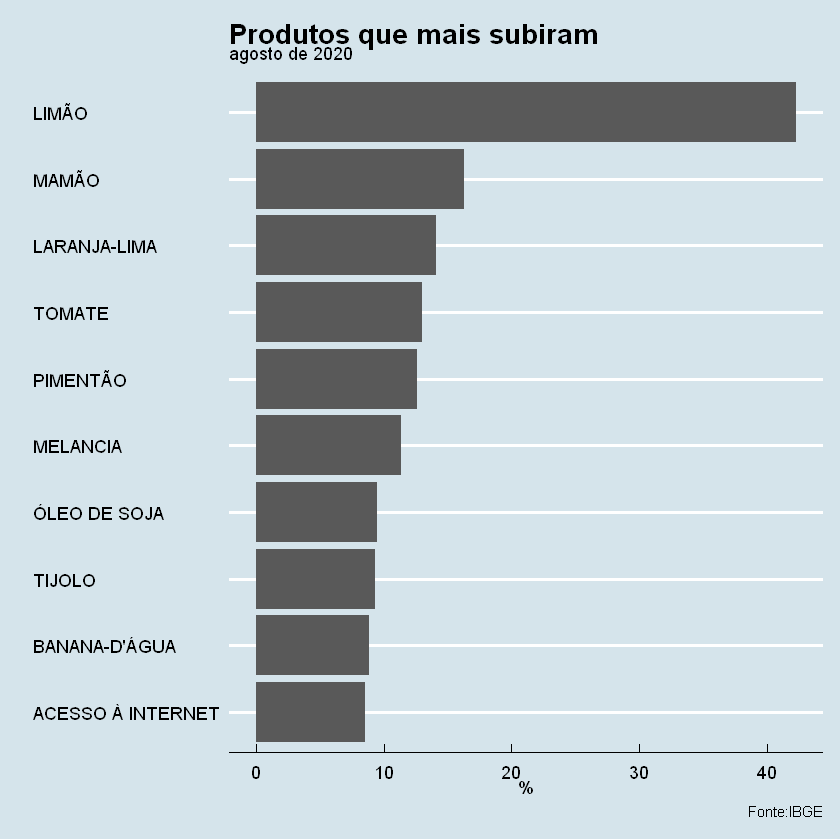

In [6]:
#Função para coleta de dados do ipca
coletando_dados <- function(lista, elemento = "ALIMENTAÇÃO E BEBIDAS",
                            estado = "SP"){
  require(stringi)
  require(stringr)
  elemento <- str_to_lower(elemento)
  elemento <- stringi::stri_trans_general(elemento, "Latin-ASCII")
  estado <- str_to_lower(estado)
  alimentos <- matrix(0,nrow = length(lista), ncol = length(estado))
  for(i in 1:nrow(alimentos)){
    if(!is.null(lista[[i]])){
      nomes <- lista[[i]][,1]
      nomes <- str_to_lower(nomes)
      nomes <- stringi::stri_trans_general(nomes, "Latin-ASCII")
      nomes <- gsub("\\d"," ",nomes, fixed = F)
      nomes <- gsub("-"," ", nomes, fixed = T)
      t <- str_detect(nomes,elemento)
      colunas <- colnames(lista[[i]]) %>% str_to_lower()
      ali <- 0
      try(ali <- lista[[i]][t,which(colnames(lista[[i]]) %in% estado)] %>%
        as.matrix())
      if(nrow(ali) == 0|ncol(ali) == 0){
        alimentos[i,] <- NA
      }else if(nrow(ali) == 1){
        alimentos[i,] <- ali[1,]
      }else{
        alimentos[i,] <- NA
      }
    }else{
      alimentos[i,] <- NA
    }
  }
  colnames(alimentos) <- estado
  return(alimentos)
}